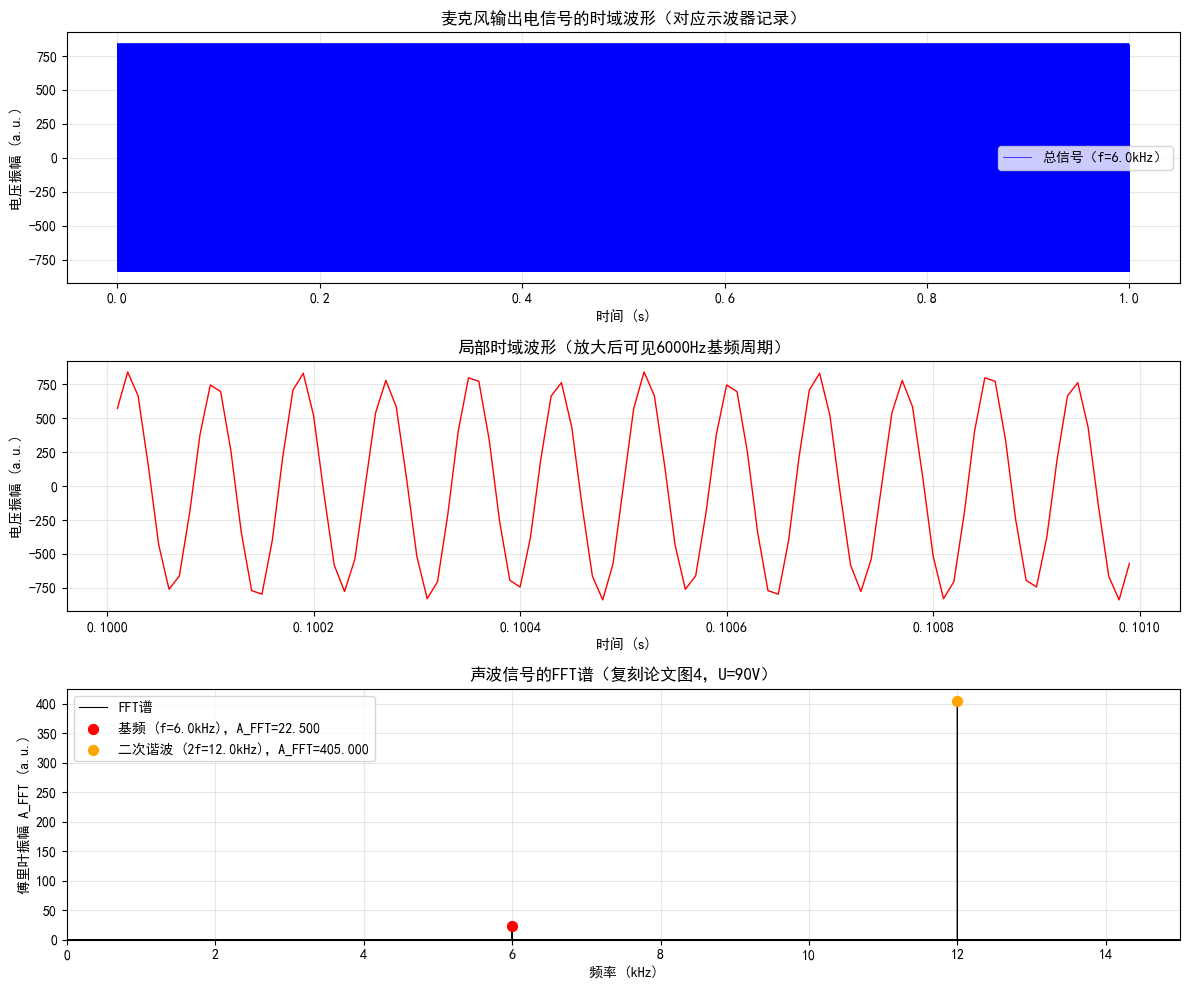

=== 傅里叶变换分析结果（U=90V, f=6.0kHz）===
基频（6.0kHz）傅里叶振幅：A_FFT = 22.500 a.u.
二次谐波（12.0kHz）傅里叶振幅：A_FFT = 405.000 a.u.
二次谐波/基频振幅比：18.00
注：活跃区（f>3kHz）时，二次谐波振幅会显著大于非活跃区（f<3kHz）


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd  

plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为“黑体”（Windows系统自带）
plt.rcParams['axes.unicode_minus'] = False    # 解决负号“-”显示为方框的问题

# -------------------------- 1. 实验参数配置------------------------------------------

sample_rate = 100000   #采样率
duration = 1.0        # 信号采集时长（1秒，足够FFT分析）
U = 90                # 驱动电压
f_drive = 6000        # 驱动电场频率（6kHz，活跃区频率，可修改为1~10kHz）

# 物理效应参数（模拟压电+电致伸缩效应）
piezo_amplitude = 0.5 * U  # 压电效应振幅（线性依赖电压U）
electrostrict_amplitude = 0.1 * U**2  # 电致伸缩效应振幅（二次依赖电压U²）
noise_amplitude = 0.05     # 背景噪声振幅（模拟实验干扰）

# -------------------------- 2. 生成/采集信号（麦克风信号模拟）--------------------------
# 生成时间轴
t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)

# 模拟麦克风输出的电信号（含基频、二次谐波、噪声，匹配论文物理机制）
# 基频（f_drive）：对应压电效应（线性响应）
signal_fundamental = piezo_amplitude * np.sin(2 * np.pi * f_drive * t)
# 二次谐波（2*f_drive）：对应电致伸缩效应（二次响应）
signal_harmonic2 = electrostrict_amplitude * np.sin(2 * np.pi * 2 * f_drive * t)
# 背景噪声（高斯噪声）
signal_noise = noise_amplitude * np.random.randn(len(t))
# 总信号（模拟麦克风放大后的电信号）
signal_total = signal_fundamental + signal_harmonic2 + signal_noise

# （可选）真实麦克风采集：替换上述模拟信号（需连接麦克风）
# signal_total = sd.rec(int(sample_rate * duration), samplerate=sample_rate, channels=1)
# sd.wait()  # 等待采集完成
# signal_total = signal_total.flatten()  # 转为一维数组

# -------------------------- 3. 时域波形可视化（对应示波器显示）--------------------------
plt.figure(figsize=(12, 10))

# 子图1：时域波形（整体）
plt.subplot(3, 1, 1)
plt.plot(t, signal_total, color='blue', linewidth=0.5, label=f'总信号（f={f_drive/1000}kHz）')
plt.xlabel('时间 (s)')
plt.ylabel('电压振幅 (a.u.)')
plt.title('麦克风输出电信号的时域波形（对应示波器记录）')
plt.legend()
plt.grid(True, alpha=0.3)

# 子图2：时域波形（局部放大，看清周期）
plt.subplot(3, 1, 2)
t_local = t[(t > 0.1) & (t < 0.101)]  # 取0.1~0.101秒的局部
signal_local = signal_total[(t > 0.1) & (t < 0.101)]
plt.plot(t_local, signal_local, color='red', linewidth=1.0)
plt.xlabel('时间 (s)')
plt.ylabel('电压振幅 (a.u.)')
plt.title(f'局部时域波形（放大后可见{int(f_drive)}Hz基频周期）')
plt.grid(True, alpha=0.3)

# -------------------------- 4. 傅里叶变换（FFT）分析（核心步骤）--------------------------
# FFT计算
n = len(signal_total)  # 信号长度
freq = np.fft.fftfreq(n, d=1/sample_rate)  # 频率轴（含正负频率）
fft_result = np.fft.fft(signal_total)  # FFT结果（复数）
fft_amplitude = np.abs(fft_result) / n  # 傅里叶振幅（归一化，A_FFT）

# 只保留正频率（物理意义：声波频率为正）
positive_freq_mask = freq >= 0
freq_pos = freq[positive_freq_mask]
fft_amplitude_pos = fft_amplitude[positive_freq_mask]

# 提取基频和二次谐波的振幅（用于后续分析）
fundamental_idx = np.argmin(np.abs(freq_pos - f_drive))  # 基频索引
harmonic2_idx = np.argmin(np.abs(freq_pos - 2*f_drive))  # 二次谐波索引
A_FFT_fundamental = fft_amplitude_pos[fundamental_idx]  # 基频振幅
A_FFT_harmonic2 = fft_amplitude_pos[harmonic2_idx]      # 二次谐波振幅

# -------------------------- 5. 频率-振幅谱可视化（复刻论文图4）--------------------------
plt.subplot(3, 1, 3)
plt.plot(freq_pos/1000, fft_amplitude_pos, color='black', linewidth=0.8, label='FFT谱')
# 标记基频和二次谐波
plt.scatter(f_drive/1000, A_FFT_fundamental, color='red', s=50, zorder=5, 
            label=f'基频 (f={f_drive/1000}kHz)，A_FFT={A_FFT_fundamental:.3f}')
plt.scatter(2*f_drive/1000, A_FFT_harmonic2, color='orange', s=50, zorder=5,
            label=f'二次谐波 (2f={2*f_drive/1000}kHz)，A_FFT={A_FFT_harmonic2:.3f}')
plt.xlabel('频率 (kHz)')
plt.ylabel('傅里叶振幅 A_FFT (a.u.)')
plt.title(f'声波信号的FFT谱（复刻论文图4，U={U}V）')
plt.xlim(0, 15)  # 聚焦0~15kHz（覆盖研究中的1~10kHz）
plt.ylim(bottom=0)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# -------------------------- 6. 定量输出关键结果（匹配论文分析）--------------------------
print(f"=== 傅里叶变换分析结果（U={U}V, f={f_drive/1000}kHz）===")
print(f"基频（{f_drive/1000}kHz）傅里叶振幅：A_FFT = {A_FFT_fundamental:.3f} a.u.")
print(f"二次谐波（{2*f_drive/1000}kHz）傅里叶振幅：A_FFT = {A_FFT_harmonic2:.3f} a.u.")
print(f"二次谐波/基频振幅比：{A_FFT_harmonic2/A_FFT_fundamental:.2f}")
print("注：活跃区（f>3kHz）时，二次谐波振幅会显著大于非活跃区（f<3kHz）")